<a href="https://colab.research.google.com/github/Manonlks5/PROJET_DDEFI_2025/blob/main/projet_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pandas numpy yfinance statsmodels openpyxl fredapi

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from fredapi import Fred

# Replace this with your actual FRED API key
FRED_API_KEY = 'your_fred_api_key_here'

# Step 1: Generate a list of dates (daily from January 2019 to January 2024)
def generate_dates():
    start_date = datetime(2018, 1, 1)
    end_date = datetime(2024, 1, 1)
    dates = []

    while start_date <= end_date:
        dates.append(start_date.strftime('%Y-%m-%d'))
        start_date += timedelta(days=1)  # Increment by 1 day

    return dates

# Step 2: Get historical data for S&P 500, VIX, and Treasury yields
def get_sp500_data_with_exogenous(dates):
    try:
        # S&P 500 and VIX historical data
        sp500 = yf.Ticker("^GSPC")
        vix = yf.Ticker("^VIX")
        sp500_hist = sp500.history(start="2018-01-01", end="2024-01-01")
        vix_hist = vix.history(start="2018-01-01", end="2024-01-01")

        # Identifier for Treasury yield (3-month Treasury yield)
        tickers = {
            "3mo": "^IRX",  # 3-month Treasury yield
        }

        data_FED = []
        # Download Treasury yield data
        for label, ticker in tickers.items():
            print(f"Téléchargement des données pour {label} ({ticker})...")
            df = yf.download(ticker, start="2018-01-01", end="2024-01-01")
            df["Yield"] = df["Close"]  # Use the 'Close' column for the yields
            df = df[["Yield"]]  # Keep only the yield data
            df.rename(columns={"Yield": label}, inplace=True)
            data_FED.append(df)

        # Combine the Treasury yield data
        yield_curve = pd.concat(data_FED, axis=1, join="inner")
        yield_curve.reset_index(inplace=True)
        yield_curve.rename(columns={"Date": "Date"}, inplace=True)

        # Create the data list with merged information
        data = []
        start_date = pd.to_datetime('2018-01-01')  # Définir la date de début
        for date in dates:
            try:
              if pd.to_datetime(date) >= start_date:
                # Retrieve S&P 500 data for the current date
                price = sp500_hist.loc[date, 'Close']
                volume = sp500_hist.loc[date, 'Volume']
                vix_value = vix_hist.loc[date, 'Close']

                # Get the Treasury yield for the current date
                treasury_rate = yield_curve.loc[yield_curve['Date'] == date, '3mo'].values[0]

                # Append all data as a row
                data.append((date, price, volume, vix_value, treasury_rate))
            except KeyError:
                pass  # Skip dates where data is missing

        # Create the final DataFrame
        final_df = pd.DataFrame(data, columns=["Date", "Close", "Volume", "VIX", "3mo_Treasury_Rate"])

        # Save the DataFrame to an Excel file
        output_file = "sp500_with_treasury_yield_data.xlsx"
        final_df.to_excel(output_file, index=False)
        print(f"Data saved to {output_file}")
        return final_df

    except Exception as e:
        print(f"Error retrieving data: {e}")
        return pd.DataFrame()



# Main logic
if __name__ == "__main__":
    # Generate daily dates
    dates = generate_dates()

    # Fetch all data
    full_data = get_sp500_data_with_exogenous(dates)

    # Save to Excel
    if not full_data.empty:
        output_file = "sp500_full_data.xlsx"
        full_data.to_excel(output_file, index=False)
        print(f"Data successfully saved to {output_file}")
    else:
        print("No data to save.")


#La valeur 3223050000 pour le volume signifie qu'environ 3,223,050,000 actions (soit environ 3,2 milliards d'actions)
# ont été échangées sur l'ensemble des composantes du S&P 500 au cours de cette journée spécifique.

Téléchargement des données pour 3mo (^IRX)...


[*********************100%***********************]  1 of 1 completed


Data saved to sp500_with_treasury_yield_data.xlsx
Data successfully saved to sp500_full_data.xlsx


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Step 1: Load and clean data
def load_and_clean_data():
    # Charger les données générées par le code précédent
    input_file = "sp500_full_data.xlsx"
    data = pd.read_excel(input_file)

    # Supprimer les doublons
    data = data.drop_duplicates()

    # Gérer les valeurs manquantes
    data = data.dropna()  # Supprimer les lignes avec des valeurs manquantes
    return data

# Step 2: Transform prices into log-returns
def compute_log_returns(data):
    # Ajouter une colonne des rendements log
    data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    return data.dropna()  # Supprimer les lignes NaN créées par le décalage

# Step 3: Perform stationarity analysis (ADF Test)
def test_stationarity(data, column):
    result = adfuller(data[column], autolag='AIC')
    print(f"ADF Test for {column}:")
    print(f"Test Statistic: {result[0]}")
    print(f"P-Value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")
    return result

# Main logic
if __name__ == "__main__":
    # Charger et nettoyer les données
    data = load_and_clean_data()

    # Calculer les rendements log
    data = compute_log_returns(data)

    # Effectuer le test ADF sur les rendements log
    test_stationarity(data, 'Log_Returns')

    # Enregistrer le dataset nettoyé et enrichi avec les décalages
    output_file = "sp500_cleaned.xlsx"
    data.to_excel(output_file, index=False)
    print(f"Cleaned data with log-returns saved to {output_file}")

ADF Test for Log_Returns:
Test Statistic: -11.853423740881892
P-Value: 7.119616583190098e-22
Critical Values: {'1%': -3.4347199356122493, '5%': -2.86347004827819, '10%': -2.567797534300163}
The series is stationary.
Cleaned data with log-returns saved to sp500_cleaned.xlsx


In [ ]:
pip install pandas openpyxl ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=3d1a16a7fe67320c53d9a7ffb0f175f6f38dddd7719e837140429fd94771a754
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import pandas as pd
import ta

# Charger le fichier Excel
fichier_excel = "sp500_cleaned.xlsx"
df = pd.read_excel(fichier_excel)

# Vérifier les premières lignes pour confirmer la structure
print(df.head())

# Nettoyer et vérifier les colonnes
if "Close" not in df.columns:
    raise ValueError("Le fichier doit contenir une colonne nommée 'Close' pour les prix de clôture.")

# Vérifier et convertir la colonne "Date" en datetime
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(by="Date")  # Trier par date
else:
    raise ValueError("Le fichier doit contenir une colonne nommée 'Date'.")

# Ajouter des indicateurs techniques en utilisant toutes les données
df["SMA_50"] = df["Close"].rolling(window=50).mean()
df["SMA_200"] = df["Close"].rolling(window=200).mean()

# RSI (Relative Strength Index) sur 14 jours
df["RSI_14"] = ta.momentum.RSIIndicator(close=df["Close"], window=14).rsi()

# MACD (Moving Average Convergence Divergence)
macd = ta.trend.MACD(close=df["Close"])
df["MACD"] = macd.macd()            # Ligne MACD
df["MACD_Signal"] = macd.macd_signal()  # Ligne Signal
df["MACD_Hist"] = macd.macd_diff()  # Histogramme MACD

# Filtrer les données pour inclure uniquement celles à partir du 1er janvier 2019
start_date = pd.to_datetime("2019-01-01")
df_filtered = df[df["Date"] >= start_date]

# Vérifier les données après filtrage
print(df_filtered.head())

# Sauvegarder les données enrichies dans un nouveau fichier Excel
fichier_sortie = "s&p500_with_indicators_2019.xlsx"
df_filtered.to_excel(fichier_sortie, index=False)

print(f"Fichier enrichi avec indicateurs sauvegardé sous : {fichier_sortie}")


         Date        Close      Volume    VIX  3mo_Treasury_Rate  Log_Returns
0  2018-01-03  2713.060059  3544030000   9.15              1.370     0.006378
1  2018-01-04  2723.989990  3697340000   9.22              1.370     0.004021
2  2018-01-05  2743.149902  3239280000   9.22              1.370     0.007009
3  2018-01-08  2747.709961  3246160000   9.52              1.380     0.001661
4  2018-01-09  2751.290039  3467460000  10.08              1.415     0.001302
          Date        Close      Volume        VIX  3mo_Treasury_Rate  \
250 2019-01-02  2510.030029  3733160000  23.219999              2.365   
251 2019-01-03  2447.889893  3858830000  25.450001              2.355   
252 2019-01-04  2531.939941  4234140000  21.379999              2.358   
253 2019-01-07  2549.689941  4133120000  21.400000              2.353   
254 2019-01-08  2574.409912  4120060000  20.469999              2.400   

     Log_Returns       SMA_50     SMA_200     RSI_14       MACD  MACD_Signal  \
250     0.001

        Date        Close      Volume        VIX  3mo_Treasury_Rate  \
0 2019-01-02  2510.030029  3733160000  23.219999              2.365   
1 2019-01-03  2447.889893  3858830000  25.450001              2.355   
2 2019-01-04  2531.939941  4234140000  21.379999              2.358   
3 2019-01-07  2549.689941  4133120000  21.400000              2.353   
4 2019-01-08  2574.409912  4120060000  20.469999              2.400   

   Log_Returns       SMA_50     SMA_200     RSI_14       MACD  MACD_Signal  \
0     0.001268  2655.941201  2744.79245  42.127431 -60.803987   -61.695988   
1    -0.025068  2649.543398  2743.46730  36.601730 -61.283265   -61.613443   
2     0.033759  2645.064600  2742.54230  46.771618 -54.255535   -60.141861   
3     0.006986  2641.244600  2741.73110  48.645167 -46.715228   -57.456535   
4     0.009649  2639.610796  2741.38470  51.220276 -38.303249   -53.625878   

   MACD_Hist  
0   0.892000  
1   0.330178  
2   5.886327  
3  10.741307  
4  15.322629  


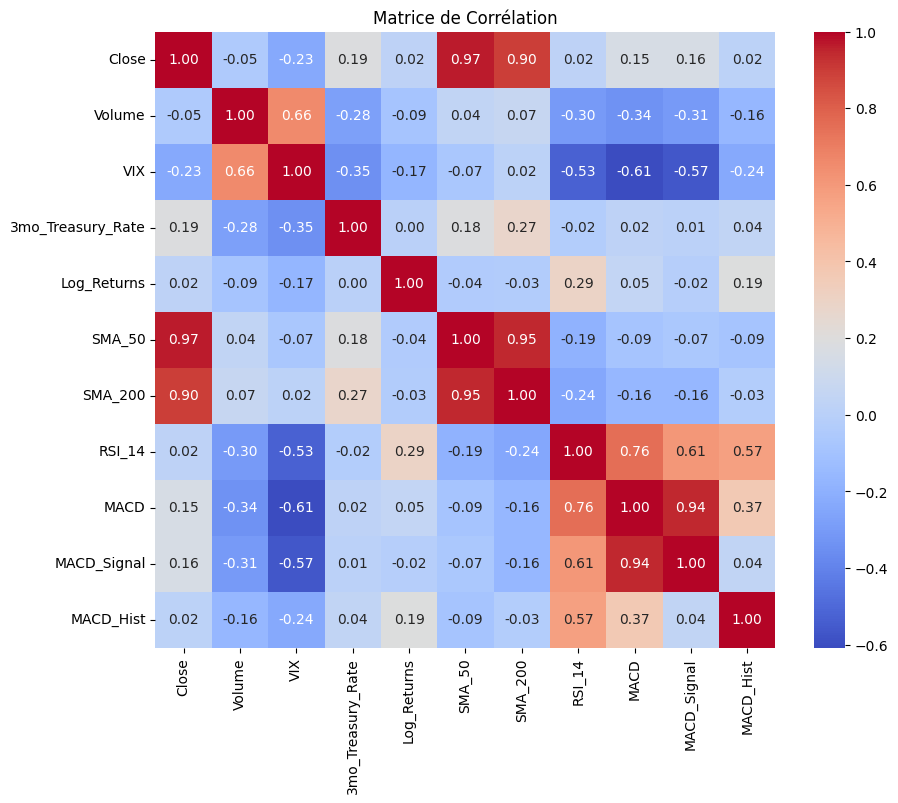

Corrélation avec 'Close':
Close                1.000000
SMA_50               0.967979
SMA_200              0.897138
3mo_Treasury_Rate    0.189502
MACD_Signal          0.157276
MACD                 0.152541
RSI_14               0.022767
Log_Returns          0.021035
MACD_Hist            0.018486
Volume              -0.047497
VIX                 -0.230662
Name: Close, dtype: float64

Variables sélectionnées avec SelectKBest :
Index(['VIX', '3mo_Treasury_Rate', 'SMA_50', 'SMA_200', 'MACD_Signal'], dtype='object')

Fichier avec features sélectionnées sauvegardé sous : s&p500_selected_features_2019.xlsx


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression

# Charger le fichier enrichi
fichier_enrichi = "s&p500_with_indicators_2019.xlsx"
df = pd.read_excel(fichier_enrichi)

# Vérifier les premières lignes pour confirmer la structure
print(df.head())

# Supprimer les colonnes non pertinentes (par exemple, Date si elle n'est pas une variable numérique)
df_numeric = df.drop(columns=["Date"])

# Calculer la matrice de corrélation
correlation_matrix = df_numeric.corr()

# Visualiser la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de Corrélation")
plt.show()

# Identifier les variables ayant une forte corrélation avec la variable cible 'Close'
correlation_with_close = correlation_matrix["Close"].sort_values(ascending=False)
print("Corrélation avec 'Close':")
print(correlation_with_close)

# Sélectionner les 5 meilleures features en utilisant SelectKBest
X = df_numeric.drop(columns=["Close"])  # Variables indépendantes
y = df_numeric["Close"]  # Variable cible

# Appliquer SelectKBest avec la méthode de régression F
selector = SelectKBest(score_func=f_regression, k=5)
X_new = selector.fit_transform(X, y)

# Obtenir les noms des variables sélectionnées
selected_features = X.columns[selector.get_support()]
print("\nVariables sélectionnées avec SelectKBest :")
print(selected_features)

# Créer un nouveau dataframe avec les features sélectionnées
df_selected = df[["Date", "Close"] + list(selected_features)]

# Sauvegarder les données dans un fichier Excel
fichier_sortie = "s&p500_selected_features_2019.xlsx"
df_selected.to_excel(fichier_sortie, index=False)

print(f"\nFichier avec features sélectionnées sauvegardé sous : {fichier_sortie}")


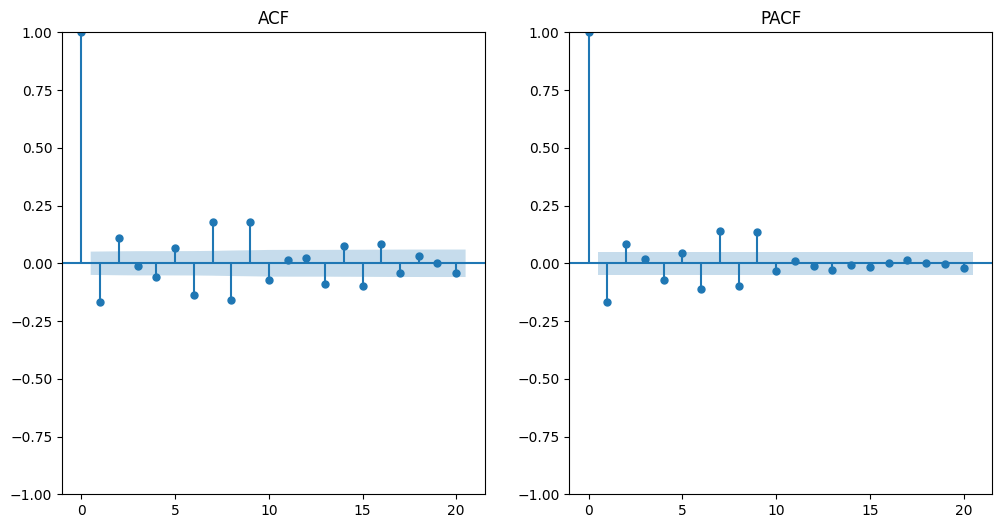

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Meilleur ordre ARIMA: (0, 0, 2) avec AIC: -8848.169579904614
Validation croisée temporelle (rolling window)...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Mean Absolute Error (MAE): 0.0076
Root Mean Squared Error (RMSE): 0.0099
Accuracy (Précision directionnelle): 0.4636


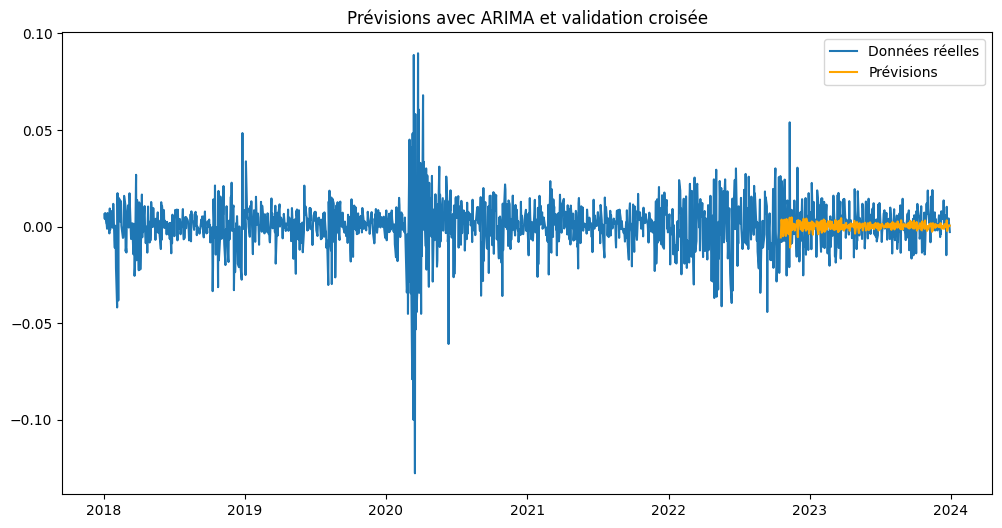

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools

# Charger la série stationnaire
def load_stationary_series():
    input_file = "sp500_cleaned.xlsx"
    series = pd.read_excel(input_file, index_col="Date", parse_dates=True)
    return series

# Tracer ACF et PACF
def plot_acf_pacf(series):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(series, ax=plt.gca(), lags=20)
    plt.title("ACF")

    plt.subplot(122)
    plot_pacf(series, ax=plt.gca(), lags=20)
    plt.title("PACF")
    plt.show()

# Recherche de l'ordre optimal pour ARIMA avec AIC/BIC
def find_best_arima(series, p_range, q_range, d=0):
    best_aic = float("inf")
    best_order = None
    for p, q in itertools.product(p_range, q_range):
        try:
            model = ARIMA(series, order=(p, d, q))
            model_fit = model.fit()
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = (p, d, q)
        except:
            continue
    print(f"Meilleur ordre ARIMA: {best_order} avec AIC: {best_aic}")
    return best_order

# Fonction de validation croisée temporelle
def rolling_window_cv(series, order, train_ratio=0.8, forecast_steps=1):
    n = len(series)
    train_size = int(n * train_ratio)
    test_size = n - train_size

    train = series[:train_size]
    test = series[train_size:]

    predictions = []
    actuals = []

    print("Validation croisée temporelle (rolling window)...")
    for i in range(len(test) - forecast_steps + 1):
        train_window = series[:train_size + i]
        test_point = series[train_size + i:train_size + i + forecast_steps]

        model = ARIMA(train_window, order=order)
        model_fit = model.fit()

        forecast = model_fit.forecast(steps=forecast_steps)
        predictions.extend(forecast)
        actuals.extend(test_point.values)

    return actuals, predictions

# Calculer les métriques d'évaluation
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Correction : Comparer les directions (hausse/baisse)
    accuracy = np.mean(np.sign(y_true) == np.sign(y_pred))  # Précision directionnelle
    return mae, rmse, accuracy

# Tracer les résultats
def plot_results(series, actuals, predictions, train_ratio):
    train_size = int(len(series) * train_ratio)

    plt.figure(figsize=(12, 6))
    plt.plot(series.index, series, label="Données réelles")
    plt.plot(series.index[train_size:], predictions, label="Prévisions", color="orange")
    plt.legend()
    plt.title("Prévisions avec ARIMA et validation croisée")
    plt.show()

# Main logic
if __name__ == "__main__":
    # Charger la série stationnaire
    series = load_stationary_series()["Log_Returns"]

    # Tracer ACF et PACF pour déterminer p et q
    plot_acf_pacf(series)

    # Déterminer l'ordre optimal de ARIMA avec une recherche exhaustive
    p_range = range(0, 4)  # Test pour p = 0, 1, 2, 3
    q_range = range(0, 4)  # Test pour q = 0, 1, 2, 3
    best_order = find_best_arima(series, p_range, q_range, d=0)  # d = 0 car la série est stationnaire

    # Validation croisée temporelle avec le meilleur ordre ARIMA
    actuals, predictions = rolling_window_cv(series, best_order)

    # Calculer les métriques
    mae, rmse, accuracy = evaluate_model(actuals, predictions)
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Accuracy (Précision directionnelle): {accuracy:.4f}")

    # Tracer les résultats
    plot_results(series, actuals, predictions, train_ratio=0.8)


<ipython-input-9-90efb1f058c3>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(series[i])  # Le rendement du jour à prédire


Mean Absolute Error (MAE): 0.0076
Root Mean Squared Error (RMSE): 0.0099


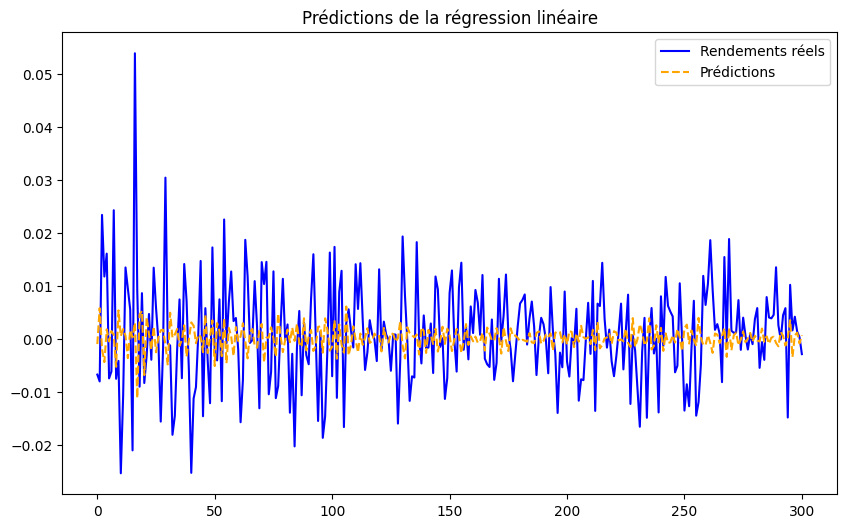

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Charger la série temporelle
def load_stationary_series():
    input_file = "sp500_cleaned.xlsx"
    series = pd.read_excel(input_file, index_col="Date", parse_dates=True)
    return series

# Fonction pour préparer les caractéristiques (features) et les cibles (targets)
def prepare_data(series, lag=1):
    X = []
    y = []

    # Utilisation des rendements passés pour prédire les rendements futurs
    for i in range(lag, len(series)):
        X.append(series[i-lag:i].values)  # Les rendements des jours précédents comme caractéristiques
        y.append(series[i])  # Le rendement du jour à prédire

    return np.array(X), np.array(y)

# Fonction pour entraîner et évaluer le modèle de régression linéaire
def train_and_evaluate_linear_regression(X_train, y_train, X_test, y_test):
    # Initialisation du modèle de régression linéaire
    model = LinearRegression()

    # Entraînement du modèle
    model.fit(X_train, y_train)

    # Prédiction sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Calcul des métriques d'évaluation
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Retourner les métriques
    return mae, rmse, y_pred

# Fonction pour tracer les résultats
def plot_results(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label="Rendements réels", color="blue")
    plt.plot(y_pred, label="Prédictions", color="orange", linestyle='--')
    plt.legend()
    plt.title("Prédictions de la régression linéaire")
    plt.show()

# Main logic
if __name__ == "__main__":
    # Charger la série temporelle
    series = load_stationary_series()["Log_Returns"]

    # Préparer les données avec des décalages (lags)
    lag = 5  # Utiliser les 5 derniers rendements pour prédire le rendement suivant
    X, y = prepare_data(series, lag=lag)

    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Entraîner et évaluer le modèle de régression linéaire
    mae, rmse, y_pred = train_and_evaluate_linear_regression(X_train, y_train, X_test, y_test)

    # Afficher les métriques
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    # Tracer les résultats
    plot_results(y_test, y_pred)
